[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/biodatlab/deep-learning-skooldio/blob/master/03_handwritten_recognition_explore.ipynb)

## **Thai-digit handwritten classification with Pytorch: Exploration**

This notebook contains exploration of the "Thai-digit handwritten classification" including
- Customize model
    - Adding layers
    - Adding dropout layer
- Adding data augmentation

## **Download and clean the dataset from the repository**

- We have downloaded the data from https://github.com/kittinan/thai-handwriting-number by cloning the repository
- Remove files that have character mismatch (as suggested by the the creator)
- Then, we put the cleaned data at https://github.com/biodatlab/deep-learning-skooldio

In [1]:
!git clone https://github.com/biodatlab/deep-learning-skooldio

Cloning into 'deep-learning-skooldio'...
remote: Enumerating objects: 1834, done.
remote: Counting objects: 100% (1834/1834), done.
remote: Compressing objects: 100% (1794/1794), done.
remote: Total 1834 (delta 74), reused 1792 (delta 40), pack-reused 0
Receiving objects: 100% (1834/1834), 13.55 MiB | 13.53 MiB/s, done.
Resolving deltas: 100% (74/74), done.


After cloning the repository, check that `deep-learning-skooldio` should appear in the directory.

In [2]:
import os
import os.path as op
from glob import glob
from pathlib import Path
import random
from PIL import Image
from collections import Counter
from torch.utils.data import ConcatDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
directory = "deep-learning-skooldio/"
paths = glob(op.join(directory, "thai-handwritten-dataset", "*", "*"))
num_samples = len(paths)
print("Number of samples", num_samples)

Number of samples 1750


In [4]:
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import shutil

train_paths, test_paths = train_test_split(paths, test_size=0.1, random_state=42)
for i in range(10):
    os.makedirs(f"data/train/{i}", exist_ok=True)
    os.makedirs(f"data/validation/{i}", exist_ok=True)

In [5]:
def copy_to_destination(src_paths, dst_path: str = "data/train/"):
    for path in tqdm(src_paths):
        path = Path(path)
        if path.parent.name == "10":
            parent_dir = "0"
        else:
            parent_dir = path.parent.name
        shutil.copy(path, op.join(dst_path, parent_dir, path.name))

In [6]:
copy_to_destination(train_paths, "data/train/")
copy_to_destination(test_paths, "data/validation/")

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

## **Create a custom dataset and a dataloader**

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [9]:
# Create dataframe
train_df = pd.DataFrame({"path": glob("data/train/*/*")})
val_df = pd.DataFrame({"path": glob("data/validation/*/*")})

# Create text column from path
train_df["text"] = train_df["path"].apply(lambda x: int(Path(x).parent.name))
val_df["text"] = val_df["path"].apply(lambda x: int(Path(x).parent.name))

# Shape of dataframe
print("Number of train images = {}, number of validation images = {},".format(train_df.shape, val_df.shape))

Number of train images = (1575, 2), number of validation images = (175, 2),


In [10]:
class ThaiDigitDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.transform = transform
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label = int(self.dataframe['text'][idx])
        image = Image.open(self.dataframe['path'][idx])
        if self.transform:
            image = 1 - self.transform(image)
        return image, label

In [11]:
train_thaidigit_dataset = ThaiDigitDataset(train_df, transform=transform)
val_thaidigit_dataset = ThaiDigitDataset(val_df, transform=transform)

In [12]:
train_loader = DataLoader(train_thaidigit_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_thaidigit_dataset, batch_size=16, shuffle=False)

## **Create the model**

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class ThaiDigitNet(nn.Module):
    def __init__(self):
        super(ThaiDigitNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

## **Train the model**

In [14]:
# Create training loop function
def train(model, n_epochs, loss_function, optimizer, train_loader, validation_loader):
    training_logs = {"train_loss": [],  "train_acc": [], "val_loss": [], "val_acc": []}
    print("-"*80)
    for epoch in range(1, n_epochs+1):
        # training
        model.train()
        train_loss, correct = 0, 0
        for images, labels in train_loader:
            pred = model(images)
            loss = loss_function(pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += (pred.argmax(1) == labels).float().sum().item()
        # save training logs
        training_logs["train_loss"].append(train_loss/ len(train_loader))
        training_logs["train_acc"].append(correct / len(train_loader.dataset))

        # validation
        model.eval()
        val_loss, correct = 0, 0
        for images, labels in validation_loader:
            pred = model(images)
            val_loss += loss_function(pred, labels).item()
            correct += (pred.argmax(1) == labels).float().sum().item()
        # save validation logs
        training_logs["val_loss"].append(val_loss/ len(val_loader))
        training_logs["val_acc"].append(correct / len(validation_loader.dataset))

        print(f"Epochs {epoch}".ljust(10), 
              f"train loss {training_logs['train_loss'][-1]:.5f}",
              f"train acc {training_logs['train_acc'][-1]:.5f}",

              f"val loss {training_logs['val_loss'][-1]:.5f}",
              f"val acc {training_logs['val_acc'][-1]:.5f}",
              )
        print("-"*80)
    return model, training_logs
        

In [15]:
n_epoch = 50

net = ThaiDigitNet() # Initialize the model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
net, net_history = train(net, n_epoch, loss_fn, optimizer, train_loader, val_loader)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.29232 train acc 0.14984 val loss 2.28345 val acc 0.18286
--------------------------------------------------------------------------------
Epochs 2   train loss 2.25674 train acc 0.24317 val loss 2.25334 val acc 0.21714
--------------------------------------------------------------------------------
Epochs 3   train loss 2.21156 train acc 0.29397 val loss 2.21239 val acc 0.27429
--------------------------------------------------------------------------------
Epochs 4   train loss 2.15289 train acc 0.38667 val loss 2.15880 val acc 0.32000
--------------------------------------------------------------------------------
Epochs 5   train loss 2.07810 train acc 0.41778 val loss 2.09046 val acc 0.35429
--------------------------------------------------------------------------------
Epochs 6   train loss 1.99068 train acc 0.45778 val loss 2.01215 val acc 0.38286
----------------------------

In [18]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["val_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["val_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

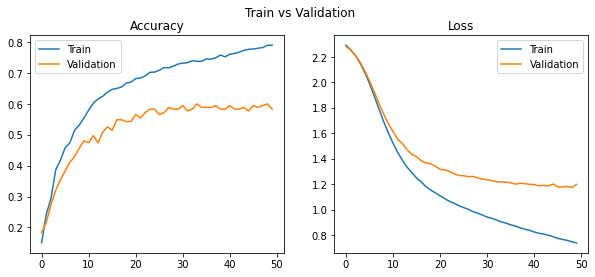

In [19]:
plot_graph(net_history)

## **Save and load model**



In [20]:
save_path = "thai_digit.pth"
torch.save(net.state_dict(), save_path)  # save model parameters

In [21]:
model_path = "thai_digit.pth"
model = ThaiDigitNet()  # initialize the model
model.load_state_dict(torch.load(model_path))  # load the model weights

<All keys matched successfully>

## **Evaluate the model**

In [22]:
# Create evaluation function for the model
def evaluate(dataframe, model):
    model.eval()
    results = dataframe.copy()
    predictions = []
    for idx, row in results.iterrows():
        img = transform(Image.open(row.path))
        pred = model(1 - img)
        predictions.append(pred.argmax(1).item())

    results["prediction"] = predictions
    # Calculate accuracy
    accuracy = len(results[results.prediction == results.text]) / len(results)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return results

In [23]:
evaluate(val_df, model)

Accuracy: 58.29%


,path,text,prediction
0,data/validation/7/cf5ffe38-3822-44d1-8c11-e04c...,7,7
1,data/validation/7/6ef7bb23-bbec-40fe-8f97-4bc2...,7,7
2,data/validation/7/d43229b0-faa7-498e-987f-0213...,7,7
3,data/validation/7/5f700dba-fecf-4a3f-b49a-2fad...,7,9
4,data/validation/7/98f01bd2-e214-433f-a848-ecf4...,7,3
...,...,...,...
170,data/validation/1/0b7155a7-4e52-4485-a675-d533...,1,2
171,data/validation/1/c04b59ea-0a6c-4dee-8e7c-45e3...,1,1
172,data/validation/1/ddfe8d4f-f032-4d2f-9248-9638...,1,0
173,data/validation/1/297b1457-bf0c-4d92-847d-69e1...,1,4


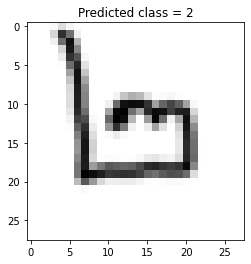

In [24]:
# Show some random images with their predicted number
random_number = random.randint(0, len(val_df))
img = Image.open(val_df.iloc[random_number].path)
img = transform(img)
transformed_img = 1 - img

pred = model(transformed_img).argmax(1)
plt.title(f"Predicted class = {pred.numpy()[0]}")
plt.imshow(img.squeeze(0), cmap="gray")
plt.show()

## **Train neural netowrk model with more layers**

In [26]:
# TODO: Create neural network with more layers
class ThaiDigitMoreLayers(nn.Module):
    def __init__(self):
        super(ThaiDigitMoreLayers, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 392)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(392, 196)
        self.fc3 = nn.Linear(196, 98)
        self.fc4 = nn.Linear(98, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

In [27]:
n_epochs = 50

more_layers_model = ThaiDigitMoreLayers()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(more_layers_model.parameters(), lr=0.01)

more_layers_model, more_layers_model_history = train(
    more_layers_model, n_epochs, loss_fn, optimizer, train_loader, val_loader
)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.30556 train acc 0.10032 val loss 2.29968 val acc 0.09714
--------------------------------------------------------------------------------
Epochs 2   train loss 2.30369 train acc 0.10032 val loss 2.29956 val acc 0.09714
--------------------------------------------------------------------------------
Epochs 3   train loss 2.30186 train acc 0.10286 val loss 2.29929 val acc 0.09143
--------------------------------------------------------------------------------
Epochs 4   train loss 2.30050 train acc 0.11302 val loss 2.29897 val acc 0.10286
--------------------------------------------------------------------------------
Epochs 5   train loss 2.29885 train acc 0.10921 val loss 2.29862 val acc 0.13714
--------------------------------------------------------------------------------
Epochs 6   train loss 2.29732 train acc 0.13524 val loss 2.29799 val acc 0.15429
----------------------------

In [31]:
evaluate(val_df, more_layers_model)

Accuracy: 59.43%


,path,text,prediction
0,data/validation/7/cf5ffe38-3822-44d1-8c11-e04c...,7,7
1,data/validation/7/6ef7bb23-bbec-40fe-8f97-4bc2...,7,7
2,data/validation/7/d43229b0-faa7-498e-987f-0213...,7,7
3,data/validation/7/5f700dba-fecf-4a3f-b49a-2fad...,7,9
4,data/validation/7/98f01bd2-e214-433f-a848-ecf4...,7,3
...,...,...,...
170,data/validation/1/0b7155a7-4e52-4485-a675-d533...,1,2
171,data/validation/1/c04b59ea-0a6c-4dee-8e7c-45e3...,1,1
172,data/validation/1/ddfe8d4f-f032-4d2f-9248-9638...,1,4
173,data/validation/1/297b1457-bf0c-4d92-847d-69e1...,1,1


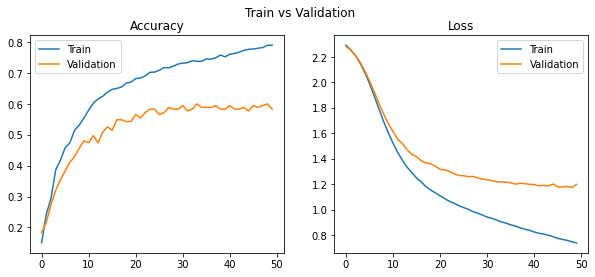

In [32]:
plot_graph(net_history)

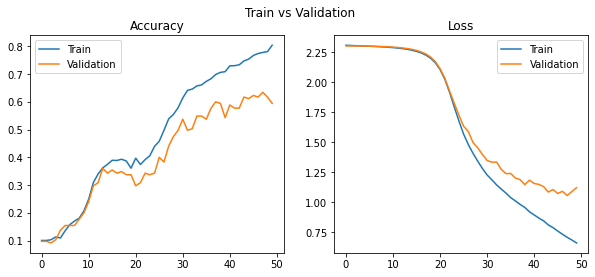

In [33]:
plot_graph(more_layers_model_history)

The training accuracy of the model is higher than the validation accuracy.
This means that the model is overfitting the training data.
We can try to reduce the overfitting by adding regularization .

## **Regularization with Dropout**

Dropout is one of the techniques used to prevent overfitting

In [34]:
# TODO: Add Dropout layer to the previous neural network
class DropoutThaiDigit(nn.Module):
    def __init__(self):
        super(DropoutThaiDigit, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 392)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(392, 196)
        self.fc3 = nn.Linear(196, 98)
        self.fc4 = nn.Linear(98, 10)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [35]:
n_epochs = 50
drop_model = DropoutThaiDigit()  # Initialize a model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(drop_model.parameters(), lr=0.01)

drop_model, drop_model_history = train(drop_model, n_epochs, loss_fn, optimizer, train_loader, val_loader)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.30523 train acc 0.09905 val loss 2.29893 val acc 0.10286
--------------------------------------------------------------------------------
Epochs 2   train loss 2.30366 train acc 0.09524 val loss 2.29882 val acc 0.10286
--------------------------------------------------------------------------------
Epochs 3   train loss 2.30165 train acc 0.10032 val loss 2.29859 val acc 0.09714
--------------------------------------------------------------------------------
Epochs 4   train loss 2.30054 train acc 0.10476 val loss 2.29827 val acc 0.09714
--------------------------------------------------------------------------------
Epochs 5   train loss 2.29892 train acc 0.12000 val loss 2.29784 val acc 0.12000
--------------------------------------------------------------------------------
Epochs 6   train loss 2.29763 train acc 0.14222 val loss 2.29720 val acc 0.12571
----------------------------

In [36]:
results = evaluate(val_df, drop_model)

Accuracy: 60.00%


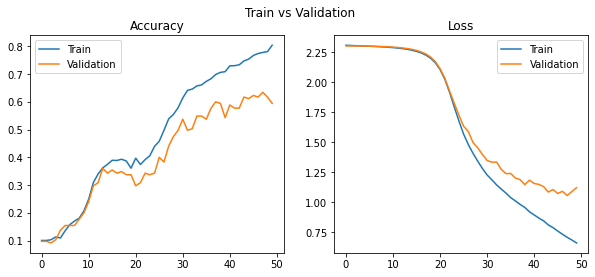

In [37]:
plot_graph(more_layers_model_history)

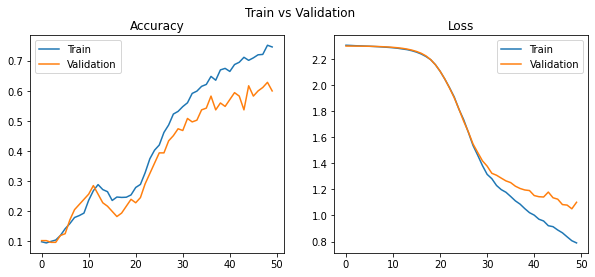

In [38]:
plot_graph(drop_model_history)

Now the gap between the training accuracy and validation accuracy is smaller than before.

## **Image Augmentation**

Image augmentation is a technique used to artificially increase the size of a training dataset by creating modified versions of existing images.

In [43]:
# TODO: Add image augmentation in `train_transform`

train_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    # add here
    transforms.RandomAffine(degrees=(-15, 15), translate=(0.05, 0.1), scale=(1, 1)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

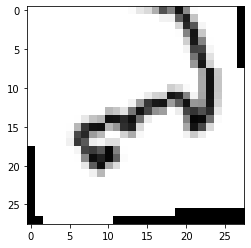

In [47]:
# TODO: Transform image using `train_transform`

# Example of augmented image
path = glob("deep-learning-skooldio/thai-handwritten-dataset/*/*")[20]
img = Image.open(path)

tranformed_img = train_transform(img).squeeze(0)
plt.imshow(tranformed_img, cmap="gray")
plt.show()

In [48]:
augmented_train_dataset = ThaiDigitDataset(train_df, transform=train_transform)
val_dataset = ThaiDigitDataset(val_df, transform=val_transform)

In [49]:
train_dataset = ConcatDataset([train_thaidigit_dataset, augmented_train_dataset])

In [50]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [51]:
# Let's train the model with augmented data
n_epochs = 50
augmented_model = DropoutThaiDigit()  # Initialize the model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(augmented_model.parameters(), lr=0.01)

augmented_model, augmented_model_history = train(
    augmented_model, n_epochs, loss_fn, optimizer, train_dataloader, val_dataloader
)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.30315 train acc 0.10381 val loss 2.30367 val acc 0.15429
--------------------------------------------------------------------------------
Epochs 2   train loss 2.30093 train acc 0.12571 val loss 2.30264 val acc 0.18857
--------------------------------------------------------------------------------
Epochs 3   train loss 2.29917 train acc 0.12794 val loss 2.30146 val acc 0.21143
--------------------------------------------------------------------------------
Epochs 4   train loss 2.29722 train acc 0.14000 val loss 2.29972 val acc 0.16571
--------------------------------------------------------------------------------
Epochs 5   train loss 2.29387 train acc 0.16317 val loss 2.29706 val acc 0.18286
--------------------------------------------------------------------------------
Epochs 6   train loss 2.29000 train acc 0.17175 val loss 2.29294 val acc 0.20571
----------------------------

In [52]:
# Evaluate the new model with old dataset.
results = evaluate(val_df, augmented_model)

Accuracy: 80.00%


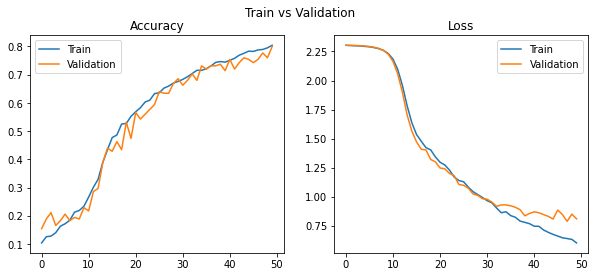

In [53]:
plot_graph(augmented_model_history)

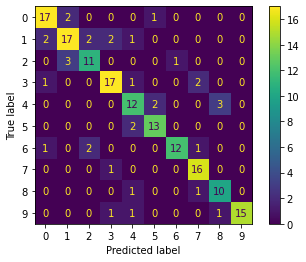

In [54]:
# Confusion matrix
cm = confusion_matrix(results.text, results.prediction, labels=range(10))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
display.plot()
plt.show()